In [6]:
import cv2
import os
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [5]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/77/df/b56175c3fb5bc058774bdcf35f5a71cf9c3c5b909f98a1c688eb71cd3b1f/opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 3.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# Loading the training data

In [11]:
data_dir = '/Users/saninzulphi/Downloads/lb6/train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,/Users/saninzulphi/Downloads/lb6/train/maligna...,malignant
1,/Users/saninzulphi/Downloads/lb6/train/maligna...,malignant
2,/Users/saninzulphi/Downloads/lb6/train/maligna...,malignant
3,/Users/saninzulphi/Downloads/lb6/train/maligna...,malignant
4,/Users/saninzulphi/Downloads/lb6/train/maligna...,malignant
...,...,...
2632,/Users/saninzulphi/Downloads/lb6/train/benign/...,benign
2633,/Users/saninzulphi/Downloads/lb6/train/benign/...,benign
2634,/Users/saninzulphi/Downloads/lb6/train/benign/...,benign
2635,/Users/saninzulphi/Downloads/lb6/train/benign/...,benign


# Loading the testing data

In [12]:

data_dir = r'/Users/saninzulphi/Downloads/lb6/test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,/Users/saninzulphi/Downloads/lb6/test/malignan...,malignant
1,/Users/saninzulphi/Downloads/lb6/test/malignan...,malignant
2,/Users/saninzulphi/Downloads/lb6/test/malignan...,malignant
3,/Users/saninzulphi/Downloads/lb6/test/malignan...,malignant
4,/Users/saninzulphi/Downloads/lb6/test/malignan...,malignant
...,...,...
655,/Users/saninzulphi/Downloads/lb6/test/benign/6...,benign
656,/Users/saninzulphi/Downloads/lb6/test/benign/1...,benign
657,/Users/saninzulphi/Downloads/lb6/test/benign/8...,benign
658,/Users/saninzulphi/Downloads/lb6/test/benign/1...,benign


# Data Preprocessing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=15,  # Random rotations
        horizontal_flip=True,  # Random horizontal flips
        zoom_range=0.1  # Random zoom
    )

    # For testing, only rescaling is needed
    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def load_data_with_generator(train_dir, test_dir, img_size=64, batch_size=32):
    train_datagen, test_datagen = create_datagen()

    # Create a training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    # Create a testing data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    return train_generator, test_generator

# Define your directories
train_dir = '/Users/saninzulphi/Downloads/lb6/train/'
test_dir = '/Users/saninzulphi/Downloads/lb6/test'

train_generator, test_generator = load_data_with_generator(train_dir, test_dir)



Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


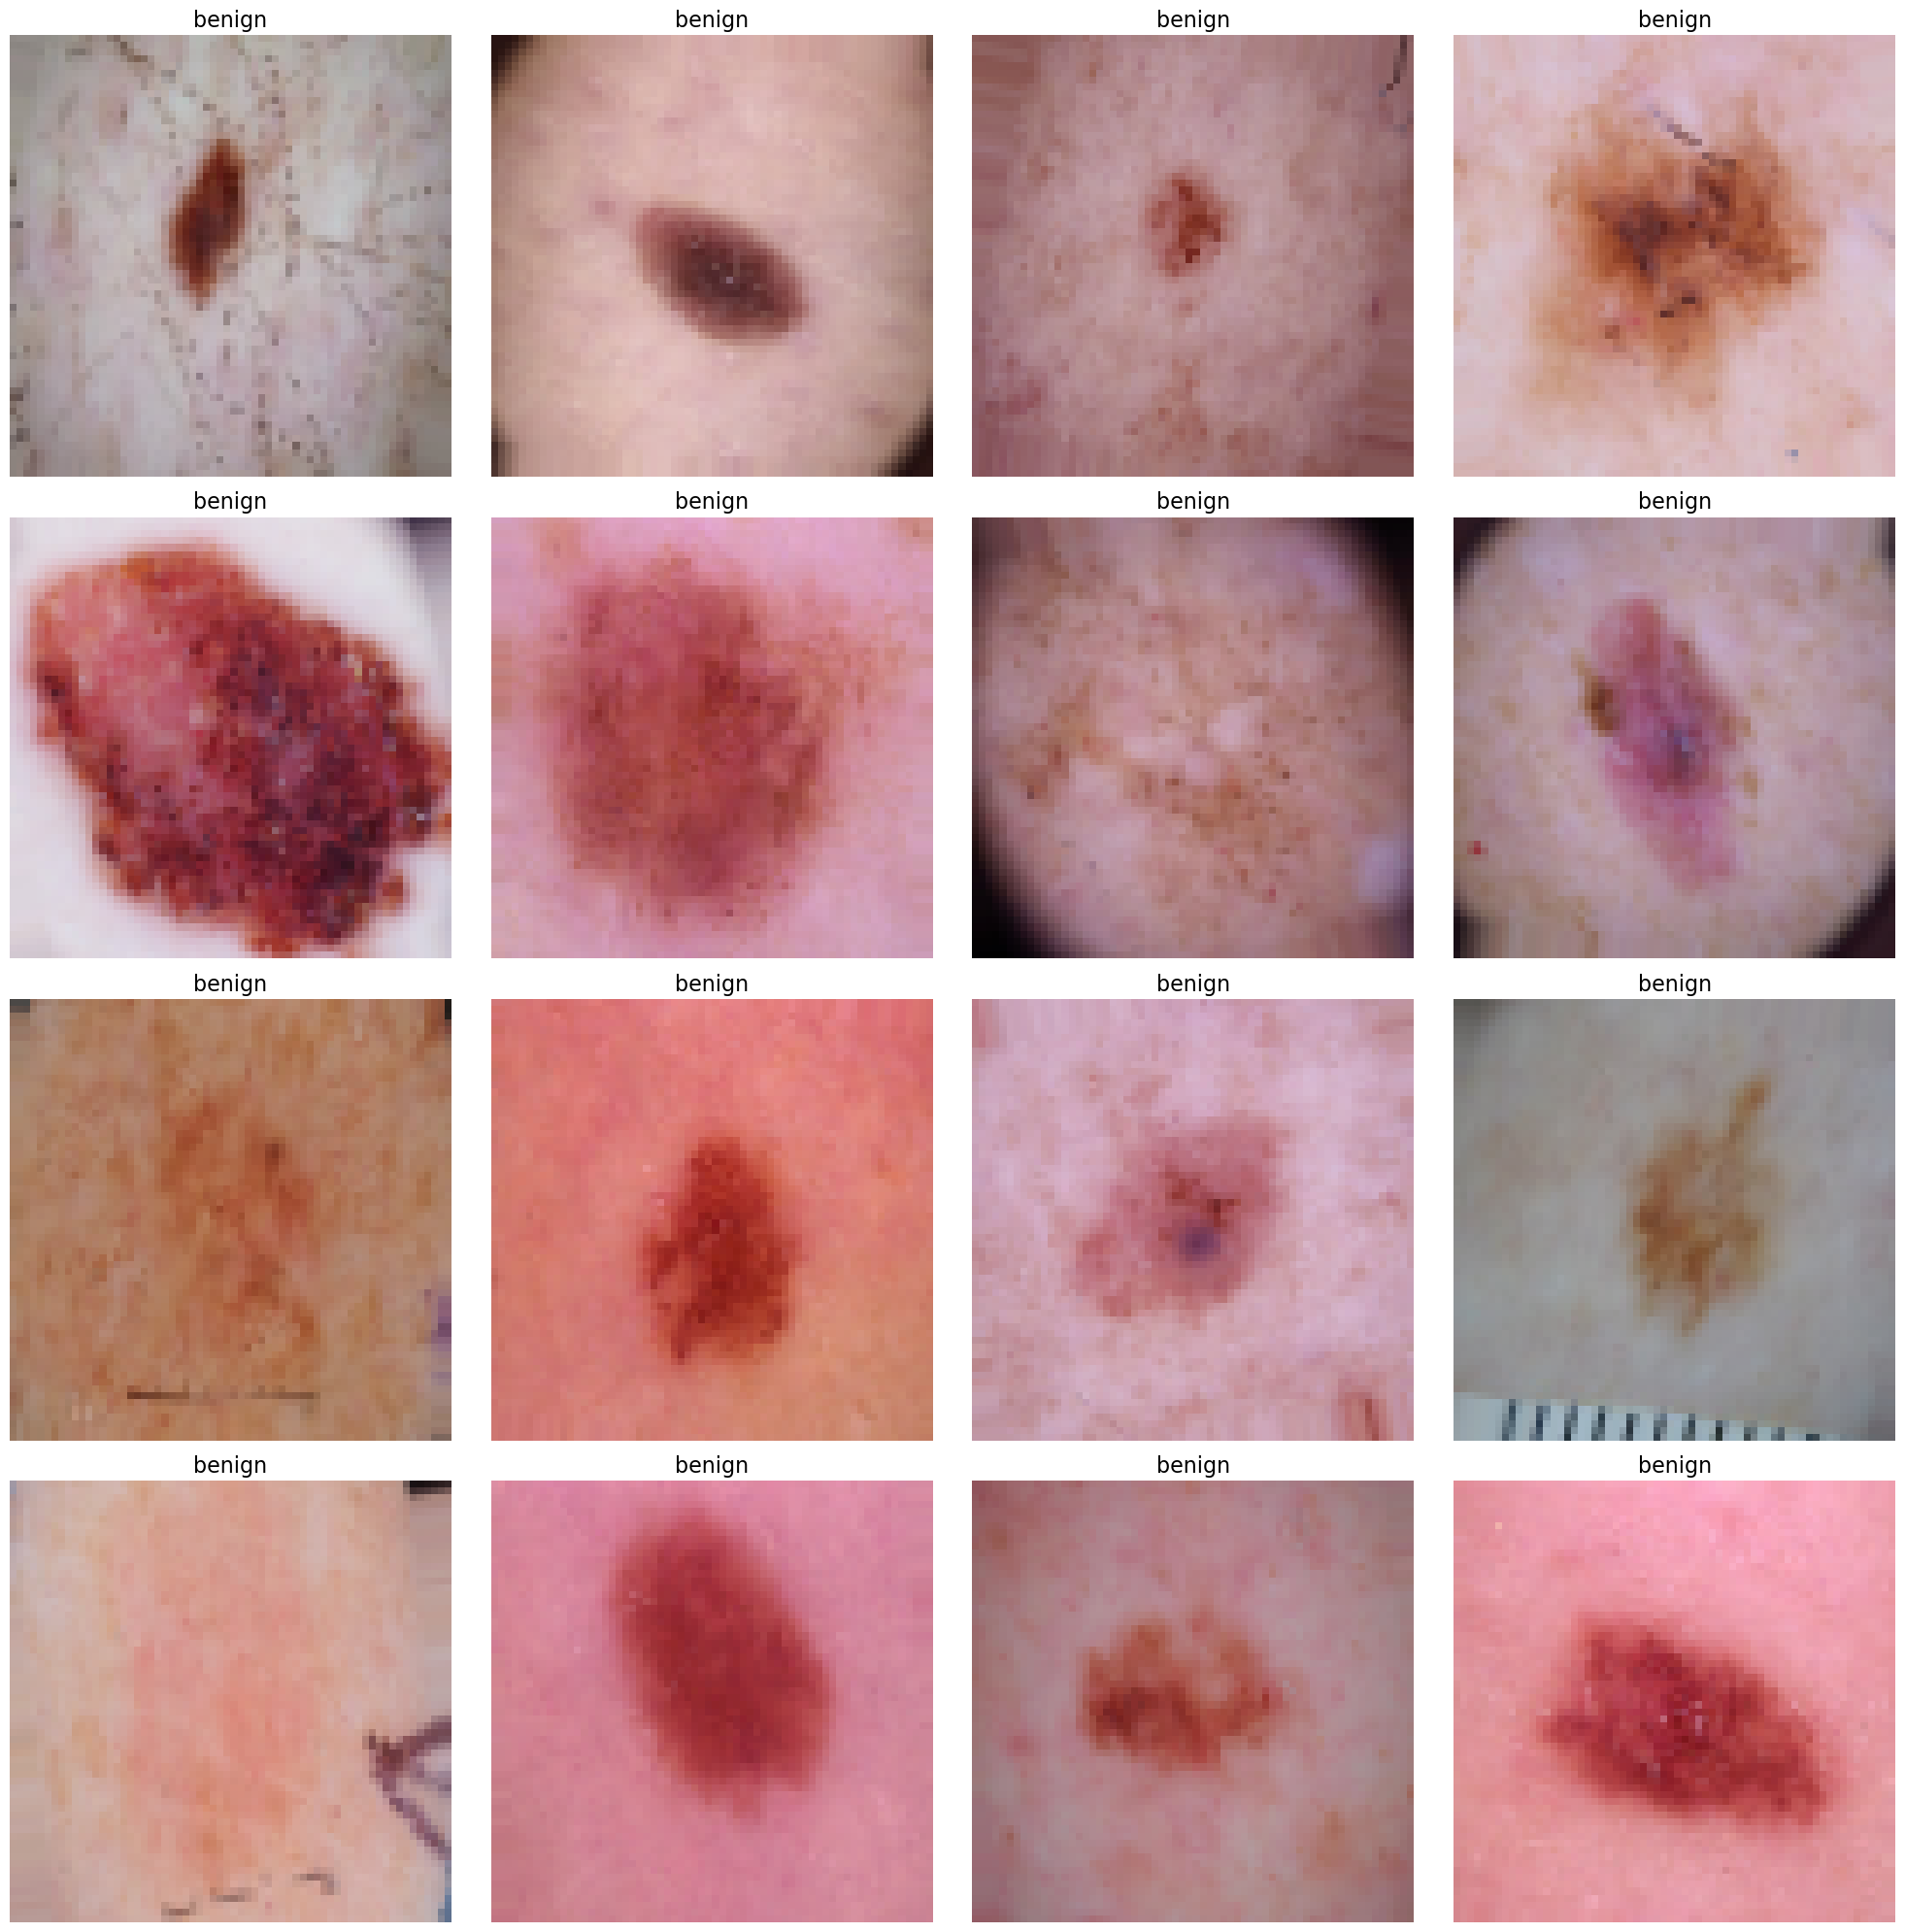

In [15]:
def display_sample_images(generator):
    """
    Display a batch of images from a data generator.
    """
    images, labels = next(generator)  
    classes = list(generator.class_indices.keys())  
    
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i]) 
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
        if i == 15:  
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)


# Build Custom CNN

In [16]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    return model

custom_cnn_model = build_custom_cnn((64, 64, 3), 1)

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

/Users/saninzulphi/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,176,385 (4.49 MB)

 Trainable params: 1,176,385 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=10,  
    batch_size=32)  

Epoch 1/10


/Users/saninzulphi/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5440 - loss: 0.6879 - val_accuracy: 0.7439 - val_loss: 0.5627
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7501 - loss: 0.5234 - val_accuracy: 0.7288 - val_loss: 0.5052
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7729 - loss: 0.4793 - val_accuracy: 0.7545 - val_loss: 0.4718
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7943 - loss: 0.4289 - val_accuracy: 0.8045 - val_loss: 0.4080
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8111 - loss: 0.4148 - val_accuracy: 0.7955 - val_loss: 0.4198
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7823 - loss: 0.4606 - val_accuracy: 0.8379 - val_loss: 0.3896
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8004 - loss: 0.4017 - val_accuracy: 0.7864 - val_loss: 0.4048
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7752 - loss: 0.4465 - val_accuracy: 0.7545 - val_loss: 0.

In [18]:
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8384 - loss: 0.3469
Test accuracy: 0.8272727131843567, Test loss: 0.3582264482975006


In [19]:
test_generator.reset() 
predictions_custom_cnn = custom_cnn_model.predict(test_generator)
predicted_classes_custom_cnn = (predictions_custom_cnn > 0.5).astype(int)
true_classes = test_generator.classes

print("Custom CNN Model Evaluation")
print(classification_report(true_classes, predicted_classes_custom_cnn))

fpr, tpr, thresholds = roc_curve(true_classes, predictions_custom_cnn)
roc_auc = auc(fpr, tpr)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Custom CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       360
           1       0.48      0.57      0.52       300

    accuracy                           0.52       660
   macro avg       0.53      0.53      0.52       660
weighted avg       0.53      0.52      0.52       660



# VGG16 Model

In [20]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg16_model = build_vgg16_model((64, 64, 3), 1)

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, 
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 326ms/step - accuracy: 0.7180 - loss: 0.5813 - val_accuracy: 0.8182 - val_loss: 0.4020
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - accuracy: 0.8004 - loss: 0.4242 - val_accuracy: 0.8091 - val_loss: 0.3881
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 328ms/step - accuracy: 0.8160 - loss: 0.3995 - val_accuracy: 0.8197 - val_loss: 0.3718
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.8438 - loss: 0.3639 - val_accuracy: 0.8242 - val_loss: 0.3667
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 322ms/step - accuracy: 0.8412 - loss: 0.3699 - val_accuracy: 0.8182 - val_loss: 0.3483
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 322ms/step - accuracy: 0.8233 - loss: 0.3647 - val_accuracy: 0.8182 - val_loss: 0.3519
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 323ms/step - accuracy: 0.8218 - loss: 0.3685 - val_accuracy: 0.8439 - val_loss: 0.3571
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 325ms/step - accuracy: 0.8243 - loss: 0.3730 - val_accu

In [22]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.8298 - loss: 0.3568
Test accuracy: 0.8333333134651184, Test loss: 0.33499425649642944


In [23]:
test_generator.reset()  
predictions_vgg16 = vgg16_model.predict(test_generator)
predicted_classes_vgg16 = (predictions_vgg16 > 0.5).astype(int)

print("VGG16 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg16))

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(true_classes, predictions_vgg16)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       360
           1       0.46      0.47      0.46       300

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660



# Build the VGG19 Model

In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers

def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg19_model = build_vgg19_model((64, 64, 3), 1)

vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [25]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 402ms/step - accuracy: 0.6428 - loss: 0.7134 - val_accuracy: 0.7985 - val_loss: 0.4695
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 411ms/step - accuracy: 0.8006 - loss: 0.4502 - val_accuracy: 0.8242 - val_loss: 0.3889
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 408ms/step - accuracy: 0.7976 - loss: 0.4272 - val_accuracy: 0.8030 - val_loss: 0.4195
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.8063 - loss: 0.4060 - val_accuracy: 0.8227 - val_loss: 0.3901
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 409ms/step - accuracy: 0.8093 - loss: 0.4063 - val_accuracy: 0.8379 - val_loss: 0.3477
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 409ms/step - accuracy: 0.8255 - loss: 0.3807 - val_accuracy: 0.8076 - val_loss: 0.3929
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 411ms/step - accuracy: 0.8216 - loss: 0.3855 - val_accuracy: 0.8394 - val_loss: 0.3453
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 411ms/step - accuracy: 0.8304 - loss: 0.3718 - val_accu

In [26]:
test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.8452 - loss: 0.3375
Test accuracy: 0.842424213886261, Test loss: 0.33909326791763306


In [27]:
test_generator.reset()  
predictions_vgg19 = vgg19_model.predict(test_generator)
predicted_classes_vgg19 = (predictions_vgg19 > 0.5).astype(int)


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step


In [28]:
print("VGG19 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg19))

fpr_vgg19, tpr_vgg19, thresholds_vgg19 = roc_curve(true_classes, predictions_vgg19)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

VGG19 Model Evaluation
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       360
           1       0.46      0.46      0.46       300

    accuracy                           0.51       660
   macro avg       0.51      0.51      0.51       660
weighted avg       0.51      0.51      0.51       660



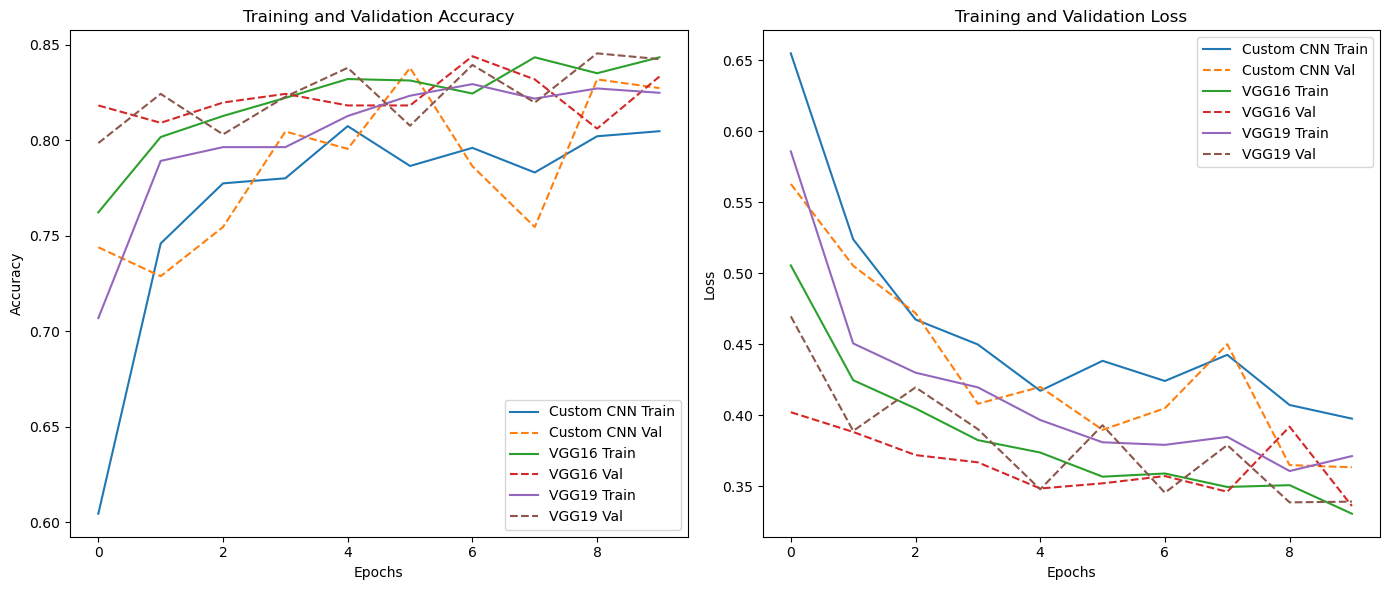

In [29]:
def plot_model_history(model_histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history[f'val_{metric}'], '--', label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{label} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(
    [history_custom_cnn, history_vgg16, history_vgg19],
    ['Custom CNN', 'VGG16', 'VGG19']
)

Custom CNN Model Confusion Matrix


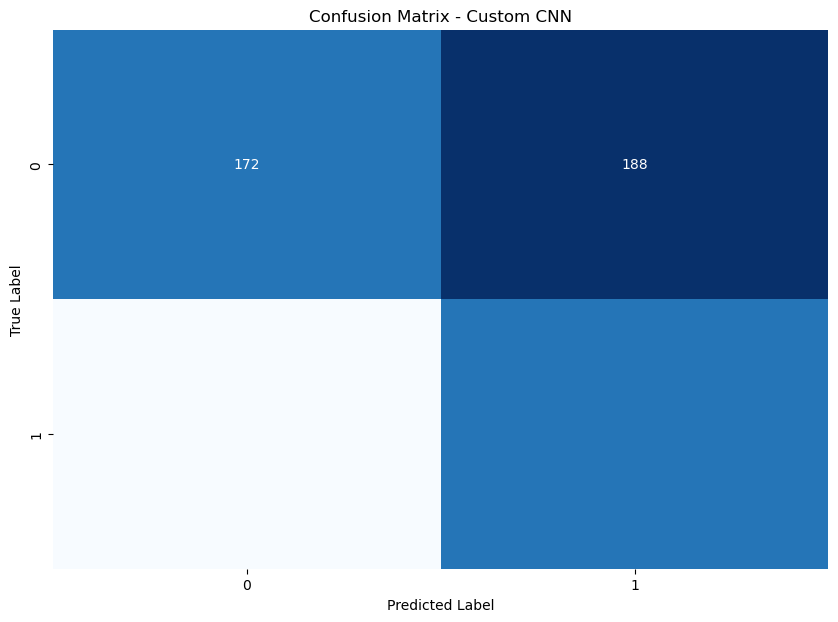

VGG16 Model Confusion Matrix


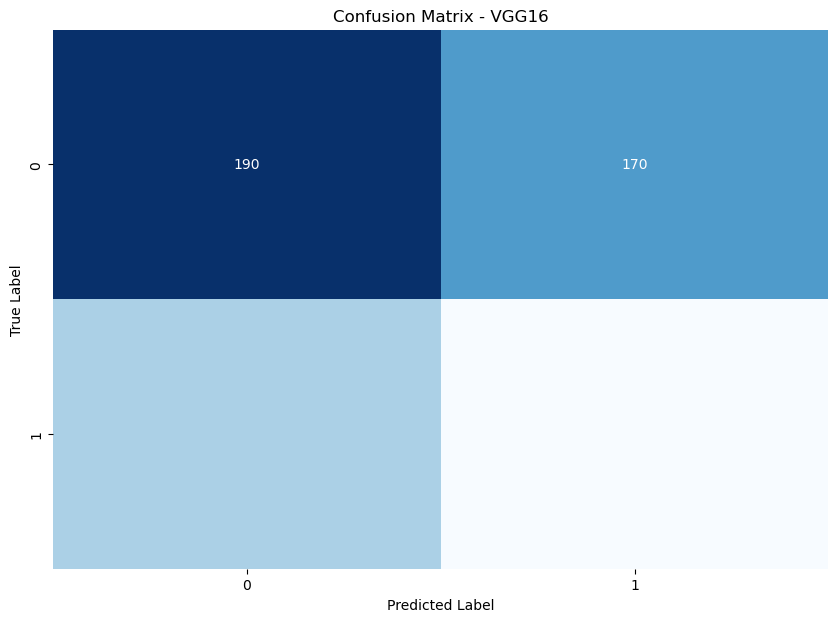

VGG19 Model Confusion Matrix


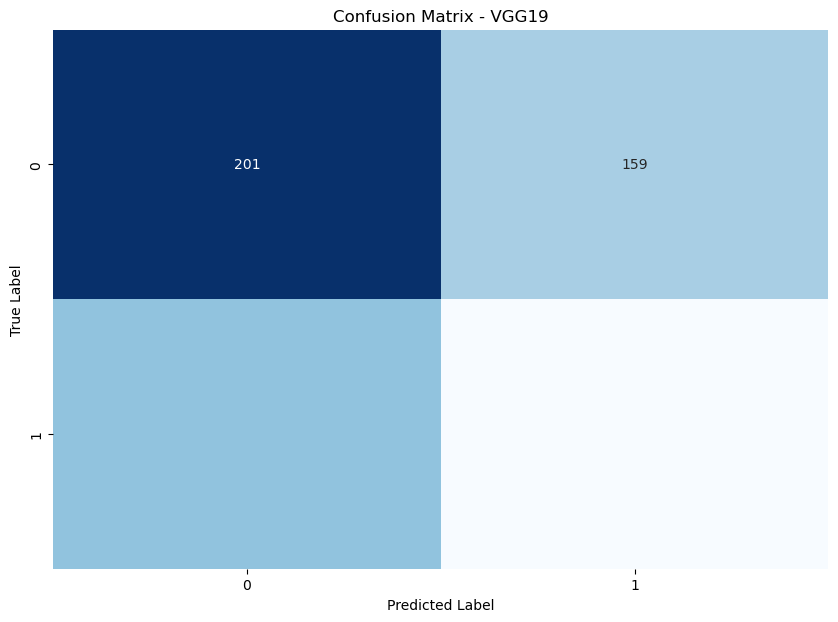

In [30]:
def plot_confusion_matrix(true_classes, predicted_classes, title='Confusion Matrix'):
    matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Custom CNN Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_custom_cnn, 'Confusion Matrix - Custom CNN')

print("VGG16 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg16, 'Confusion Matrix - VGG16')

print("VGG19 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg19, 'Confusion Matrix - VGG19')


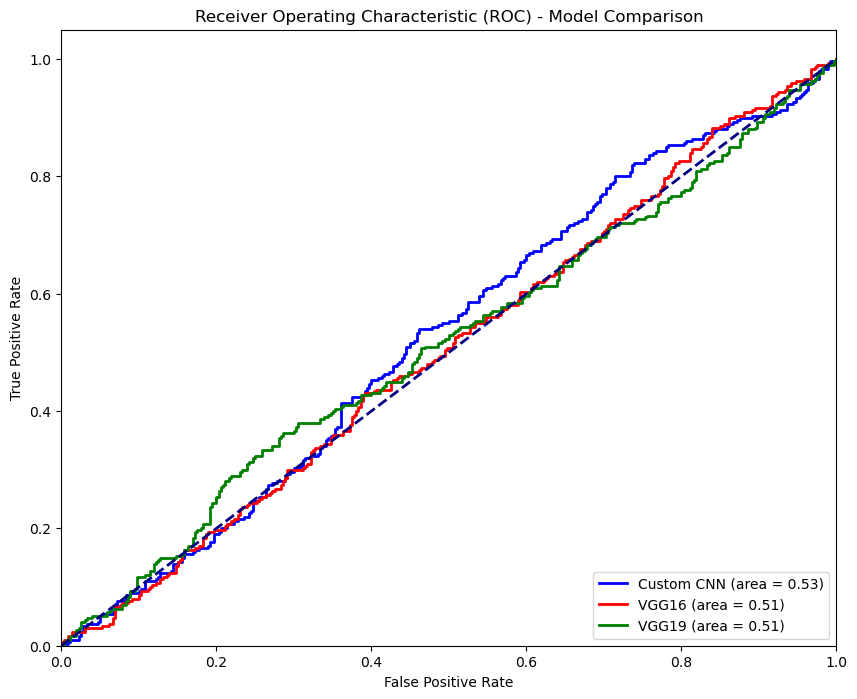

In [31]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Custom CNN (area = {roc_auc:.2f})')

plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 (area = {roc_auc_vgg16:.2f})')

plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label=f'VGG19 (area = {roc_auc_vgg19:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Comparison')
plt.legend(loc="lower right")
plt.show()